## Setup

In [642]:
import mne
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP
import scipy.io
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from pyrcn.echo_state_network import ESNClassifier

import cupy as cp

## Parameters

In [708]:
subject_id = 1
t_start = 0.0
t_end = 4.0

## Load data

In [740]:
raw = mne.io.read_raw_gdf(f'./data/train/A0{subject_id}T.gdf', preload=True)

eog_channels = [ch for ch in raw.ch_names if 'EOG' in ch]

raw.set_channel_types({ch: 'eog' for ch in eog_channels})

raw = raw.pick_types(eeg=True, eog=False)

raw = raw.filter(8, 30, picks='eeg')

eeg_data = raw.get_data(picks='eeg').T # Shape: (n_samples, n_channels)
# scaler = StandardScaler()
# eeg_data_scaled = scaler.fit_transform(eeg_data)
# robust_scaler = RobustScaler()
# eeg_data_scaled = robust_scaler.fit_transform(eeg_data)

lower_bound = np.percentile(eeg_data, 1)
upper_bound = np.percentile(eeg_data, 99)

eeg_data_scaled = np.clip(eeg_data, lower_bound, upper_bound) # Scale to microvolts
eeg_data_scaled = 1e6*eeg_data_scaled

events, event_id = mne.events_from_annotations(raw)

event_dict = {
    'left_hand':    event_id['769'], 
    'right_hand':   event_id['770'], 
    'feet':         event_id['771'], 
    'tongue':       event_id['772']
    }

print(raw.info)

Extracting EDF parameters from /home/dyxcvi/Documents/UCM/experiments/exp#1/data/train/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
<Info | 8 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 8.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 22
 projs: []
 sfreq

In [280]:
# epochs = mne.Epochs(
#     raw,
#     events,
#     event_id=event_dict,
#     tmin=t_start,  # start at cue
#     tmax=t_end,  # end of MI
#     baseline=None,
#     preload=True
# )

# X = epochs.get_data()  # shape (n_trials, n_channels, n_times)
# y = epochs.events[:, -1]

# csp = CSP(n_components=1, reg=None, log=True, norm_trace=False)
# X_csp = csp.fit_transform(X, y)

## Build reservoir

### Parameters

In [721]:
# --- ESN Hyperparameters ---
N_RESERVOIR = 500
SPECTRAL_RADIUS = 0.95
INPUT_SCALING = 1.0
SPARSITY = 0.1
READOUT_ALPHA = 100.0
LEAKY_ALPHA = 0.05
N_CHANNELS = 22 # 22 EEG channels

### Matrices initialization

In [722]:
# 1. Create Input Weights (Win)
# (N_RESERVOIR, N_CHANNELS)
W_in = (np.random.rand(N_RESERVOIR, N_CHANNELS) - 0.5) * 2 * INPUT_SCALING

# 2. Create Reservoir Weights (W)
# (N_RESERVOIR, N_RESERVOIR)
W_raw = np.random.rand(N_RESERVOIR, N_RESERVOIR) - 0.5

# 3. Apply Sparsity
# Create a mask and apply it
sparsity_mask = np.random.rand(N_RESERVOIR, N_RESERVOIR) < SPARSITY
W_sparse = W_raw * sparsity_mask

# 4. Rescale Spectral Radius (The most important step)
try:
    # Find the largest absolute eigenvalue (the current spectral radius)
    current_sr = np.max(np.abs(np.linalg.eigvals(W_sparse)))
    
    # Scale W to have the desired spectral radius
    # Handle division by zero if current_sr is 0 (unlikely but possible)
    if current_sr == 0:
        W = W_sparse
    else:
        W = W_sparse * (SPECTRAL_RADIUS / current_sr)
        
except np.linalg.LinAlgError:
    print("Warning: Eigenvalue computation did not converge. Using unscaled W.")
    W = W_sparse

print("Reservoir matrices W_in and W created.")

Reservoir matrices W_in and W created.


### Feed 

In [726]:
# --- 3. Generate "Readout" Training Data (From Scratch) ---
print("Generating training data for readout...")
X_train_readout = [] # List to hold reservoir states
y_train_readout = [] # List to hold labels

sfreq = int(raw.info['sfreq']) # 250 Hz
washout_samples = int(0.5 * sfreq)  # 0.5s washout (125 samples)
record_samples = int(2.5 * sfreq)   # 2.5s MI (625 samples)

trial_starts = [e[0] for e in events if e[2] in event_dict.values()]

sample_step = 25
pool = 0

data = eeg_data_scaled

# Loop over each trial
for start_sample in tqdm(trial_starts):
    label = events[events[:, 0] == start_sample][0, 2]
    
    # Initialize the reservoir state to zeros
    state = np.zeros(N_RESERVOIR)
    
    # 1. "Washout" (Fixation cross: t=0 to t=2s)
    washout_start = start_sample - washout_samples # t=-0.5
    washout_end = start_sample   # t=0
    
    for k in range(washout_start, washout_end):
        x_k = data[k] # Get EEG data at time k
        # x_k = np.mean(data[k-pool: k], axis=0) # Get EEG data at time k
        # x_k = np.mean(data[washout_start:k], axis=0) # Get EEG data at time k

        # ESN Update Equation (Washout):
        state = (1 - LEAKY_ALPHA) * state + LEAKY_ALPHA * np.tanh( np.dot(W_in, x_k) + np.dot(W, state) )

    # 2. "Record" (Motor Imagery: t=2 to t=6s)
    record_start = start_sample                 # t=0
    record_end = start_sample + record_samples  # t = 2.5

    trial_states = [] # To store states *for this trial*
    for k in range(record_start, record_end):
        x_k = data[k]
        # x_k = np.mean(data[k-pool:k], axis=0)
        # x_k = np.mean(data[record_start:k], axis=0)

        # ESN Update Equation (Record):
        state = (1 - LEAKY_ALPHA) * state + LEAKY_ALPHA * np.tanh( np.dot(W_in, x_k) + np.dot(W, state) )
        
        trial_states.append(state)
    
    # Use all states
    X_train_readout.append(np.array(trial_states))
    y_train_readout.append(np.full((len(trial_states),), label))
    # Use average state
    # X_train_readout.append(np.mean(trial_states, axis=0))
    # y_train_readout.append(label)
    # Use last state
    # X_train_readout.append(trial_states[-1])
    # y_train_readout.append(label)


# Stack all states and labels into big matrices
X_train = np.vstack(X_train_readout)
y_train = np.hstack(y_train_readout)

print(f"Collected {X_train.shape[0]} state samples.")

X_train.shape, y_train.shape, X_train_readout[0].shape

Generating training data for readout...


100%|██████████| 288/288 [00:37<00:00,  7.63it/s]


Collected 180000 state samples.


((180000, 500), (180000,), (625, 500))

Checking EEG signal properties...


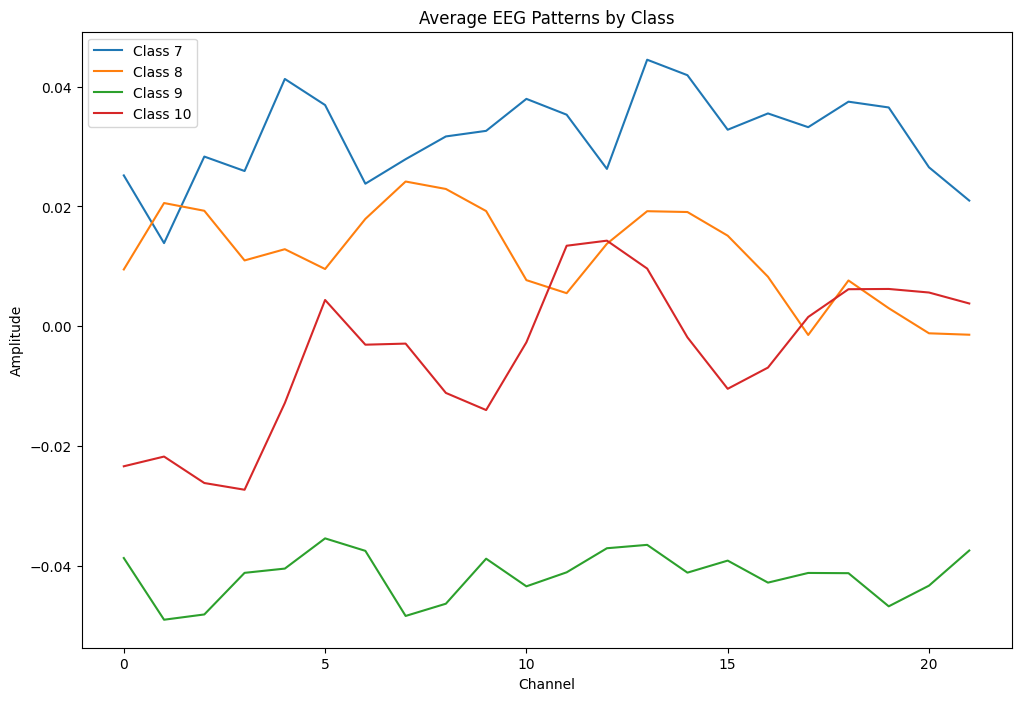

In [725]:
# Check if EEG data itself is discriminative
print("Checking EEG signal properties...")

# Take average EEG patterns for each class
class_eeg_patterns = {}
for label in np.unique(y_train):
    trial_indices = np.where(y_train == label)[0][:5]  # First 5 trials of each class
    class_patterns = []
    for idx in trial_indices:
        start = trial_starts[idx]
        eeg_segment = eeg_data_scaled[start:start + record_samples]
        class_patterns.append(np.mean(eeg_segment, axis=0))
    class_eeg_patterns[label] = np.mean(class_patterns, axis=0)

# Plot average EEG patterns
plt.figure(figsize=(12, 8))
for label, pattern in class_eeg_patterns.items():
    plt.plot(pattern, label=f'Class {label}')
plt.legend()
plt.title('Average EEG Patterns by Class')
plt.xlabel('Channel')
plt.ylabel('Amplitude')
plt.show()

### Train readout layer

In [727]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# readout_model = RandomForestClassifier(n_estimators=5, random_state=42)

# readout_model = LogisticRegression(C=1.0, penalty='l2', max_iter=1000)

# readout_model = SVC(kernel='linear', C=1.0)

readout_model = RidgeClassifier(alpha=READOUT_ALPHA)

# alphas_to_test = np.logspace(1, 4, 10) 

# readout_model = RidgeClassifierCV(
#     alphas=alphas_to_test,
#     scoring='accuracy',  # Use accuracy for CV scoring
#     store_cv_values=False,
#     fit_intercept=True
# )

readout_model.fit(X_train, y_train)

y_pred = readout_model.predict(X_train)

kappa = cohen_kappa_score(y_train, y_pred)

acc = accuracy_score(y_train, y_pred)

print(f"Alpha: {READOUT_ALPHA}")
y_pred = readout_model.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print(f'Accuracy on training data: {acc*100:.2f}%')
kappa = cohen_kappa_score(y_train, y_pred)
print(f"Cohen's Kappa: {kappa:.3f}")
# 3. Show a confusion matrix
cm = confusion_matrix(y_train, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("Readout model is trained and frozen.")

from sklearn.model_selection import cross_val_score, StratifiedKFold

# 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(readout_model, X_train, y_train, cv=cv, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# If CV scores are much lower than training accuracy, you're overfitting

/home/dyxcvi/Documents/UCM/experiments/exp#1/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Alpha: 100.0
Accuracy on training data: 44.40%
Cohen's Kappa: 0.259

Confusion Matrix:
[[19728  8658  7993  8621]
 [ 7913 20282  8447  8358]
 [ 8327  8353 19759  8561]
 [ 8289  8681  7878 20152]]
Readout model is trained and frozen.


/home/dyxcvi/Documents/UCM/experiments/exp#1/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/dyxcvi/Documents/UCM/experiments/exp#1/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/dyxcvi/Documents/UCM/experiments/exp#1/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/dyxcvi/Documents/UCM/experiments/exp#1/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/dyxcvi/Documents/UCM/experiments/exp#1/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Cross-validation scores: [0.43644444 0.4325     0.43975    0.43780556 0.43811111]
Mean CV accuracy: 0.437 (+/- 0.005)


/home/dyxcvi/Documents/UCM/experiments/exp#1/.venv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


Explained variance ratio: [0.44116017 0.13322035]
Total explained variance: 0.574


IndexError: index 2 is out of bounds for axis 0 with size 2

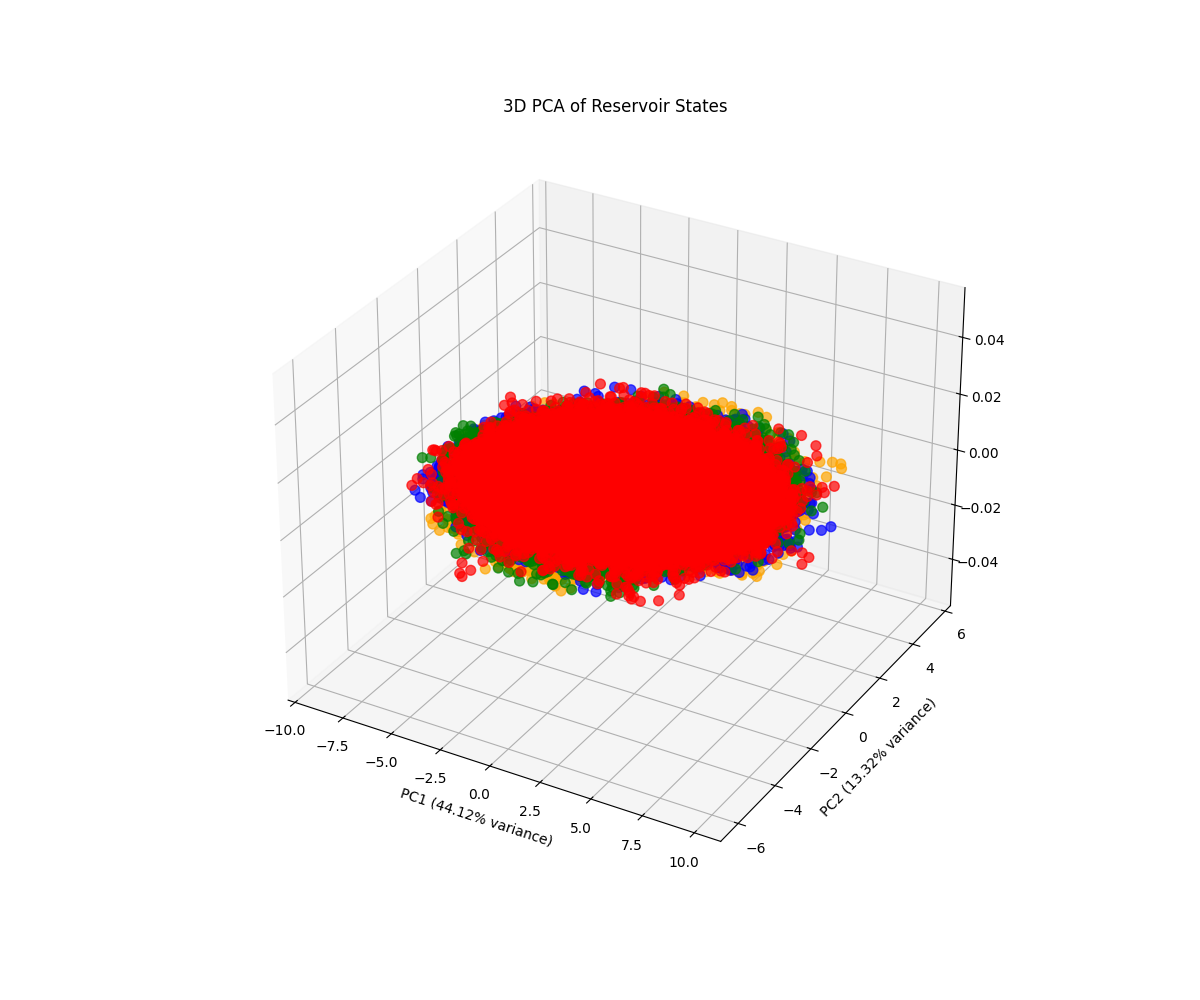

In [751]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# PCA visualization of reservoir states in 3D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_):.3f}")

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each class
colors = {7: 'red', 8: 'blue', 9: 'green', 10: 'orange'}
label_names = {7: 'Left Hand', 8: 'Right Hand', 9: 'Feet', 10: 'Tongue'}

# Plot each class
for label in np.unique(y_train):
    mask = y_train == label
    # ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2], c=colors[label], label=label_names[label], alpha=0.7, s=50)
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[label], label=label_names[label], alpha=0.7, s=50)

ax.set_title('3D PCA of Reservoir States')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
# ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)')
ax.legend()

plt.tight_layout()
plt.show()

In [748]:
eeg_data_raw = raw.get_data(picks='eeg').T
print("Raw EEG data statistics:")
print(f"  Mean: {np.mean(eeg_data_raw):.6f}")
print(f"  Std: {np.std(eeg_data_raw):.6f}")
print(f"  Range: [{np.min(eeg_data_raw):.6f}, {np.max(eeg_data_raw):.6f}]")

Raw EEG data statistics:
  Mean: -0.000000
  Std: 0.000011
  Range: [-0.000646, 0.000646]


In [749]:
print("Scaled EEG data statistics:")
print(f" Mean: {np.mean(eeg_data_scaled):.6f}")
print(f" Std: {np.std(eeg_data_scaled):.6f}")
print(f" Range: [{np.min(eeg_data_scaled):.6f}, {np.max(eeg_data_scaled):.6f}]")

Scaled EEG data statistics:
 Mean: 0.000798
 Std: 5.634411
 Range: [-14.608481, 14.292670]


In [314]:
# Test alphas from 10 all the way to 10,000
alphas_to_test = np.logspace(1, 4, 10) 
# alphas_to_test = [10.0]
# [10., 21.5, 46.4, 100., 215., 464., 1000., 2154., 4641., 10000.]

best_kappa = -1
best_alpha = 0
best_model = None

pbar = tqdm(alphas_to_test)

for alpha in pbar:
    readout_model = RidgeClassifier(alpha=alpha)
    readout_model.fit(X_train, y_train)

    y_pred = readout_model.predict(X_train)

    kappa = cohen_kappa_score(y_train, y_pred)
    
    acc = accuracy_score(y_train, y_pred)

    pbar.set_description(f'Alpha: {alpha}, Acc: {acc*100:.2f}%, Kappa: {kappa:.3f}')
    
    if kappa > best_kappa:
        best_kappa = kappa
        best_alpha = alpha
        best_model = readout_model

readout_model = best_model

print(f"Best alpha: {best_alpha}")
y_pred = best_model.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print(f'Accuracy with best alpha on training data: {acc*100:.2f}%')
kappa = cohen_kappa_score(y_train, y_pred)
print(f"Final Cohen's Kappa: {kappa:.3f}")
# 3. Show a confusion matrix
cm = confusion_matrix(y_train, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("Readout model is trained and frozen.")

Alpha: 10.0, Acc: 91.32%, Kappa: 0.884: 100%|██████████| 1/1 [00:00<00:00, 53.67it/s]

Best alpha: 10.0
Accuracy with best alpha on training data: 91.32%
Final Cohen's Kappa: 0.884

Confusion Matrix:
[[68  1  1  2]
 [ 6 64  2  0]
 [ 4  1 65  2]
 [ 2  2  2 66]]
Readout model is trained and frozen.


## Visualize data

In [ ]:
# %matplotlib widget

# # --- 1. Extract CSP Features ---
# csp_viz = CSP(n_components=4, reg=None, log=True, norm_trace=False)
# X_features = csp_viz.fit_transform(X, y)

# # --- 2. Apply LDA for Dimensionality Reduction ---
# lda_viz = LinearDiscriminantAnalysis(n_components=3)

# # Fit and transform the CSP features.
# # This finds the 3 best axes for separating the 4 classes.
# X_3d = lda_viz.fit_transform(X_features, y)

# # --- 3. Plot in 3D ---
# print("Plotting 3D visualization...")

# # Create the mapping from event ID to a name (for the legend)
# label_names = {
#     7: 'Left Hand',
#     8: 'Right Hand',
#     9: 'Feet',
#     10: 'Tongue'
# }
# colors = {
#     7: 'r',
#     8: 'b',
#     9: 'g',
#     10: 'k'
# }


# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Plot each class separately
# for label_val, name in label_names.items():
#     # Find the indices of all trials belonging to this class
#     idx = (y == label_val)
    
#     # Plot only those trials
#     ax.scatter(
#         X_3d[idx, 0],  # 1st component
#         X_3d[idx, 1],  # 2nd component
#         X_3d[idx, 2],  # 3rd component
#         c=colors[label_val],
#         label=name,
#         s=50,          # marker size
#         alpha=0.6
#     )

# ax.set_title('3D Visualization of Motor Imagery Classes (CSP + LDA)')
# ax.set_xlabel('LDA Component 1')
# ax.set_ylabel('LDA Component 2')
# ax.set_zlabel('LDA Component 3')
# ax.legend()
# plt.savefig('lda_3d_visualization.png')

# print("Plot saved as 'lda_3d_visualization.png'")

NameError: name 'X' is not defined

## Evaluate

### Load eval data

### Process eval data

In [741]:
raw_eval = mne.io.read_raw_gdf(f'./data/eval/A0{subject_id}E.gdf', preload=True)

eog_channels_eval = [ch for ch in raw_eval.ch_names if 'EOG' in ch]

raw_eval.set_channel_types({ch: 'eog' for ch in eog_channels_eval})

raw_eval = raw_eval.pick_types(eeg=True, eog=False)

raw_eval.filter(8, 30, picks='eeg')

eeg_data_eval = raw_eval.get_data(picks='eeg').T # Shape: (n_samples, n_channels)

# eeg_data_scaled_eval = scaler.transform(eeg_data_eval)

# lower_bound = np.percentile(eeg_data_eval, 1)
# upper_bound = np.percentile(eeg_data_eval, 99)
eeg_data_scaled_eval = np.clip(eeg_data_eval, lower_bound, upper_bound) # Scale to microvolts
eeg_data_scaled_eval = 1e6*eeg_data_scaled_eval

events_eval, event_id_eval = mne.events_from_annotations(raw_eval)

event_dict_eval = {
    'unknown_cue': event_id_eval['783']
}

eval_trial_starts = [e[0] for e in events_eval if e[2]==event_dict_eval['unknown_cue']]

# epochs = mne.Epochs(
#     raw,
#     events,
#     event_id=event_dict_eval,
#     tmin=t_start,
#     tmax=t_end,  
#     baseline=None,
#     preload=True
# )

# X_eval = epochs.get_data()  # shape (n_trials, n_channels, n_times)

# X_eval_csp = csp.transform(X_eval)

Extracting EDF parameters from /home/dyxcvi/Documents/UCM/experiments/exp#1/data/eval/A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']


### Load true labels

In [742]:
# Load the .mat file
# Replace 'A0XE.mat' with your actual file path (e.g., 'A01E.mat')
mat_labels = scipy.io.loadmat(f'./data/true_labels/A0{subject_id}E.mat')

print("Keys in .mat file:", mat_labels.keys())

Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'classlabel'])


In [743]:
true_label_key = 'classlabel' 
y_true = mat_labels[true_label_key]

y_true = np.squeeze(y_true)

print(f"Loaded {len(y_true)} true labels.")

Loaded 288 true labels.


### Predict labels

In [744]:
print("Running continuous evaluation...")

all_trial_predictions = []

pbar = tqdm(eval_trial_starts)

pool = 0
sample_step = 100

data = eeg_data_scaled_eval

for start_sample in pbar:
    
    # Initialize the reservoir state
    state = np.zeros(N_RESERVOIR)

    washout_start = start_sample - washout_samples # t=0
    washout_end = start_sample   # t=2

    for k in range(washout_start, washout_end):
        x_k = data[k]
        # x_k = np.mean(data[k-pool: k], axis=0)
        # x_k = np.mean(data[washout_start:k], axis=0)
        state = (1 - LEAKY_ALPHA) * state + LEAKY_ALPHA * np.tanh( np.dot(W_in, x_k) + np.dot(W, state) )

    record_start = start_sample                 # t=2
    record_end = start_sample + record_samples # t=6
    
    trial_predictions = []
    
    for k in range(record_start, record_end):
        x_k = data[k]
        # x_k = np.mean(data[k-pool:k], axis=0)
        # x_k = np.mean(data[record_start:k], axis=0)

        # ESN Update Equation:
        state = (1 - LEAKY_ALPHA) * state + LEAKY_ALPHA * np.tanh( np.dot(W_in, x_k) + np.dot(W, state) )
        
        # Make a prediction with the trained readout
        # Reshape state to (1, N_RESERVOIR) for sklearn
    prediction = readout_model.predict(state.reshape(1, -1))
    trial_predictions.append(prediction[0])
    
    all_trial_predictions.append(trial_predictions)

np.array(all_trial_predictions).shape

Running continuous evaluation...


100%|██████████| 288/288 [00:48<00:00,  5.95it/s]


(288, 1)

In [ ]:
# # Test alphas from 10 all the way to 10,000
# alphas_to_test = np.logspace(1, 4, 10) 
# # [10., 21.5, 46.4, 100., 215., 464., 1000., 2154., 4641., 10000.]

# best_kappa = -1
# best_alpha = 0

# for alpha in tqdm(alphas_to_test):
#     readout_model = RidgeClassifier(alpha=alpha)
#     readout_model.fit(X_train, y_train)
    
#     # Run the "Phase 2: Causal Evaluation" loop with this model
#     # ... (run your prediction loop) ...

#     all_trial_predictions = []

#     for start_sample in eval_trial_starts:
        
#         # Initialize the reservoir state
#         state = np.zeros(N_RESERVOIR)
        
#         washout_start = start_sample # t=2
#         washout_end = start_sample + washout_samples   # t=4
        
#         for k in range(washout_start, washout_end):
#             x_k = eeg_data_scaled_eval[k]
#             state = np.tanh( np.dot(W_in, x_k) + np.dot(W, state) )
        
#         record_start = washout_end                 # t=4
#         record_end = washout_end + record_samples # t = 6
        
#         trial_predictions = []
#         for k in range(record_start, record_end):
#             x_k = eeg_data_scaled_eval[k]
            
#             # ESN Update Equation:
#             state = np.tanh( np.dot(W_in, x_k) + np.dot(W, state) )
            
#             # Make a prediction with the trained readout
#             # Reshape state to (1, N_RESERVOIR) for sklearn
#             prediction = readout_model.predict(state.reshape(1, -1))
#             trial_predictions.append(prediction[0])
        
#         all_trial_predictions.append(trial_predictions)
    
#     # Transpose the prediction matrix so we can score each time point
#     predictions_by_time = np.array(all_trial_predictions).T

#     label_map = {
#         event_id['769']: 1,  # left_hand
#         event_id['770']: 2,  # right_hand
#         event_id['771']: 3,  # feet
#         event_id['772']: 4   # tongue
#     }

#     kappa_scores = []
#     for y_pred_at_time_t in predictions_by_time:
#         # Map MNE labels (769...) to simple labels (1...)
#         y_pred_mapped = np.array([label_map[pred] for pred in y_pred_at_time_t])
        
#         # Calculate kappa for this single time slice
#         kappa = cohen_kappa_score(y_true, y_pred_mapped)
#         kappa_scores.append(kappa)

#     # --- 5. Find the Final Score ---
#     max_kappa = np.max(kappa_scores)

#     print(f"Alpha: {alpha:.2f}  --  Max Kappa: {max_kappa:.3f}")
    
#     if max_kappa > best_kappa:
#         best_kappa = max_kappa
#         best_alpha = alpha

# print(f"\nBest Kappa: {best_kappa:.3f} found at alpha={best_alpha:.2f}")

### Calculate performance

In [745]:
# Transpose the prediction matrix so we can score each time point
predictions_by_time = np.array(all_trial_predictions).T

print(predictions_by_time.shape)

label_map = {
    event_id['769']: 1,  # left_hand
    event_id['770']: 2,  # right_hand
    event_id['771']: 3,  # feet
    event_id['772']: 4   # tongue
}

kappa_scores = []
acc_scores = []
for y_pred_at_time_t in predictions_by_time:
    # Map MNE labels (769...) to simple labels (1...)
    y_pred_mapped = np.array([label_map[pred] for pred in y_pred_at_time_t])

    # Calculate kappa for this single time slice
    kappa = cohen_kappa_score(y_true, y_pred_mapped)
    kappa_scores.append(kappa)

    acc = accuracy_score(y_true, y_pred_mapped)
    acc_scores.append(acc)

# --- 5. Find the Final Score ---
max_kappa = np.max(kappa_scores)
print(f"Time course of Kappa calculated.")
print(f"Maximum Kappa value: {max_kappa:.3f}")
max_acc = np.max(acc_scores)
print(f"Maximum Accuracy value: {max_acc*100:.2f}%")

(1, 288)
Time course of Kappa calculated.
Maximum Kappa value: -0.005
Maximum Accuracy value: 24.65%


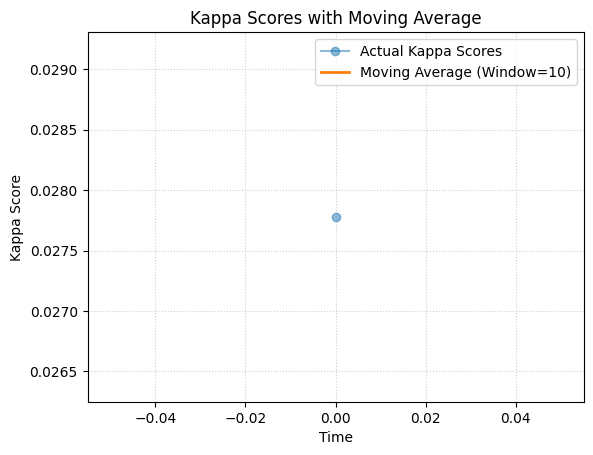

In [607]:
import pandas as pd 

# 1. Define your window size
window_size = 10

# 2. Convert your list to a pandas Series to use its tools
scores_series = pd.Series(kappa_scores)

# 3. Calculate the moving average
# .rolling() creates the window
# .mean() calculates the average for each window
moving_avg = scores_series.rolling(window=window_size).mean()

# --- Now, we plot everything ---

# Plot the original scores
plt.plot(kappa_scores, marker='o', alpha=0.5, label='Actual Kappa Scores')

# Plot the new moving average line
plt.plot(
    moving_avg,
    # marker='x',
    # linestyle='--',
    linewidth=2,
    label=f'Moving Average (Window={window_size})'
)

plt.title('Kappa Scores with Moving Average')
plt.ylabel('Kappa Score')
plt.xlabel('Time')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [388]:
# Random baseline performance 

y_pred_random = np.random.randint(1, 5, size=len(y_true))

acc = accuracy_score(y_true, y_pred_random)

print(f"Final Accuracy: {acc * 100:.2f}%")

# 2. Calculate Kappa (the competition metric)
kappa = cohen_kappa_score(y_true, y_pred_random)
print(f"Final Cohen's Kappa: {kappa:.3f}")

# 3. Show a confusion matrix
cm = confusion_matrix(y_true, y_pred_random)
print("\nConfusion Matrix:")
print(cm)

Final Accuracy: 27.78%
Final Cohen's Kappa: 0.037

Confusion Matrix:
[[19 13 20 20]
 [14 18 24 16]
 [15 15 24 18]
 [13 17 23 19]]
